# Optimisation of the parameters of the friendship-based approach

This notebook is published for the purpose of illustrating the optimisation of the parameters of the friendship-based algorithm as described in 

Calmon, L., Colosi, E., Bassignana, G., Barrat, A. and Colizza, V.
‘Preserving friendships in school contacts: an algorithm to construct
synthetic temporal networks for epidemic modelling’

(c) the authors


Empirical data loaded in this script were obtained from 
http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/.
The file provided as input was postprocessed to 
- select the four full days recorded (removing the first day)
- create the variable "t_all_days" counting time (in seconds) that resets every day at midnight.
- create a variable "t_day" counting time (in seconds) over the full data collection, initialised at midnight on day 1.
- create the variable "day" that identifies the day (2,3,4,5) over which the contacts take place.
- create the variable "w" set to the duration of each contact (=20 seconds)


Synthetic contacts loaded in this file must be generated using the file CP-2-friendship-based.py, or can be loaded from pre-computed pickled files (provided).

Please cite the following references when using this code:

[1] L. Calmon, E. Colosi, G. Bassignana, A. Barrat, and V. Colizza,
‘Preserving friendships in school contacts: an algorithm to construct
synthetic temporal networks for epidemic modelling’

[2] R. Mastrandrea, J. Fournet, A. Barrat,
Contact patterns in a high school: a comparison between data collected using wearable sensors, contact diaries and friendship surveys.
PLoS ONE 10(9): e0136497 (2015)

In [1]:
import func_both_alg_and_opt

from scipy.stats import bootstrap
from scipy.spatial import distance
import pandas as pd
import numpy as np
from numpy import mean
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib.lines import Line2D
import random
import statistics
import math
import datetime
import re
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import pickle
import os
import os.path
from os import path
import glob
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

random.seed(3579)

dir_root = ''
dir_data = dir_root + 'data_in/'

In [2]:
## PARAMETERS

days_selected = [2,3,4,5]   ## days selected in the dataset
days = days_selected

nrep_values = [2]
nrep = 2

n_copies = 10 #numbers of copies
copie_js = list(range(1,n_copies+1))
n_start  = 1
copies = np.arange(n_start,n_copies+1)

w_step = 20
s_in_day = 24 * 60 * 60
s_in_h = 60 * 60
s_in_15min = 15 * 60

#grid values, set to the following if loading the pickled files provided
f_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
P_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
t_values = [0, 0.25, 0.5, 0.75, 1]

fPt_values = []
for f in f_values:
    for P in P_values:
        for tr in t_values:
            fPt_values.append([f, P, tr])
            
len(fPt_values)

180

## Load contacts

In [3]:
## EMPIRICAL CONTACTS

str_header_md = ['t', 'n1', 'n2', 'c1', 'c2', 'day', 'w', 't_day', 't_all_days']

orig_data = pd.read_table(dir_data+'CP-tidy-2345.csv', \
                delimiter='\t', names = str_header_md)
orig_data = orig_data.astype({"t":int, "n1":int, "n2":int, "c1":str, "c2":str, \
                              "day":int, "w":int, "t_day":int, "t_all_days":int})

listclasses = sorted(list(set(orig_data.c1).union(set(orig_data.c2))))
print('listclasses: ', listclasses)

all_nodes = sorted(list(set(orig_data.n1).union(set(orig_data.n2))))
n_nodes_emp = len(all_nodes)

CP = orig_data.copy()
listclasses_emp = listclasses.copy()

n_emp_nodes_each_day = []
for day in days_selected:
    df = orig_data.copy()
    df = df[df['day']==day]
    n_emp_nodes_each_day.append(len(set(df.n1).union(set(df.n2))))
print('n_emp_nodes_each_day: ', n_emp_nodes_each_day)

###############################################################################

## AGGREGATION
## requires t from 0 to 60*60*24=86400 within each day

df = CP.copy()
df['step'] = df['t_day'].apply(func_both_alg_and_opt.intervals_15min)

### Aggregation
df1 = df.copy()
df1 = df1.groupby(['n1','n2','c1','c2','day','step']).size()
df1 = df1.reset_index()
df1.columns = ['n1','n2','c1','c2','day','step','num']
df1['w'] = df1['num'] * w_step
df1['t0'] = df1['step'] * s_in_15min
df1 = df1.sort_values(by=['day','step','n1','n2','w'])

if len(df1[df1['w']>s_in_15min]) > 0:
    print('ERROR!!! w > 15 min')
    print(df1[df1['w']>s_in_15min])

## have t across all days
df1['t_all_days'] = df1['t0'] + ((df1['day']-1)*s_in_day)

CP_15min = df1.copy()


# BUILD DAILY CONTACT NETWORKS
dict_dG = dict()
for day in days_selected:
    dict_dG[day] = nx.Graph()
    
classes = {}
composition_classes = {}
for c in listclasses:
    composition_classes[c] = set()

df0 = CP_15min.copy()

for day in days_selected:
    df = df0[df0['day']==day]
    for row in df.itertuples():
        t = row.t_all_days
        i = row.n1
        j = row.n2
        w = row.w
        ci = row.c1
        cj = row.c2
        classes[i] = ci
        classes[j] = cj
        composition_classes[ci].add(i)
        composition_classes[cj].add(j)
        
        w0 = 0
        tline = []
        if dict_dG[day].has_edge(i,j):
            w0 = dict_dG[day].get_edge_data(i,j)['weight']
            tline = dict_dG[day].get_edge_data(i,j)['timeline']
        tline.append(t % s_in_day)
        dict_dG[day].add_node(i)
        dict_dG[day].add_node(j)
        dict_dG[day].add_edge(i,j,weight = w0+w, timeline = tline, color='k')

dict_dG_emp = dict_dG.copy()
print('dict_dG_emp: ', dict_dG_emp)
print('ok.')


listclasses:  ['2BIO1', '2BIO2', '2BIO3', 'MP', 'MP*1', 'MP*2', 'PC', 'PC*', 'PSI*']
n_emp_nodes_each_day:  [310, 303, 295, 299]
dict_dG_emp:  {2: <networkx.classes.graph.Graph object at 0x15b21f910>, 3: <networkx.classes.graph.Graph object at 0x15b21e3e0>, 4: <networkx.classes.graph.Graph object at 0x15b21f9d0>, 5: <networkx.classes.graph.Graph object at 0x15b21ea10>}
ok.


In [4]:
CP_15min

,n1,n2,c1,c2,day,step,num,w,t0,t_all_days
425,4,325,PSI*,PSI*,2,36,3,60,32400,118800
554,9,48,PC,PC,2,36,2,40,32400,118800
730,9,448,PC,PC,2,36,20,400,32400,118800
748,9,453,PC,PC,2,36,7,140,32400,118800
952,14,256,PC*,PC*,2,36,2,40,32400,118800
...,...,...,...,...,...,...,...,...,...,...
20718,603,941,PC*,PC*,5,71,2,40,63900,409500
21138,626,939,2BIO3,2BIO3,5,71,7,140,63900,409500
21599,642,874,MP,MP,5,71,1,20,63900,409500
21637,649,939,2BIO3,2BIO3,5,71,1,20,63900,409500


### synthetic

In [5]:
###LOAD SYNTHETIC CONTACTS

dir_pk = 'copies-friendship-based-4d/pickle_files/'
    
dir_copies = 'copies-friendship-based-4d/copies-f%03d-P%03d-t%03d/'
TOL = 0.1

dict_dG_synrepfp_tr = dict()
dfCP_synrepfp_tr = dict()

dict_deg_synrepfp_tr = dict()

CPsynrepfp_tr_15min = dict()

kk = 0 
nrep = 2
for f,P,p_tr in fPt_values:
    kk = kk + 1 
    print('%d / %d :\trep = %d, f = %d, P = %d, p_tr = %d, TOL = %f'%(\
                kk, len(fPt_values), \
                nrep, f*100, P*100, p_tr*100, TOL))

    v = 'rep%df%dp%dt%d'%(nrep, 100*f, 100*P, p_tr*100) #LABEL OF THE PARAMETER TRIPLET USED

    ##Check if pickled file:
    if os.path.exists(dir_pk + 'dict_dG_synrepfp_tr_%s.pickle'%v):          
        a_file = open(dir_pk+'dict_dG_synrepfp_tr_%s.pickle'%v, "rb")
        dict_dG = pickle.load(a_file)    

    else: ## load contacts from input
        str_header = ['t', 'n1', 'n2', 'c1', 'c2']
        dict_dG = dict()
        for day in days_selected:
            dict_dG[day] = dict()
            for copy in copies:
                dict_dG[day][copy] = nx.Graph()

        first = True
        ###LOAD SYNTHETIC CONTACTS DAY BY DAY AND CREATE DAILY NETWORKS
        for day in days_selected:
            for copy in copies:
                file = dir_root + dir_copies%(100*f, P*100, p_tr*100) + \
                        'DAY%d/dynamic_copy_%02d.csv'%(day, copy)


                df = pd.read_csv(file, sep='\t', names=str_header)
                df['day'] = day
                df['copy'] = copy
                df['t_all_days'] = df['t'] + s_in_day*(day-1)
                df['w'] = w_step

                n_nodes = len(set(df.n1).union(set(df.n2)))
                tempi = sorted(list(df.t))

                if first == True:
                    first = False
                    CPsyn = df.copy()
                else:
                    CPsyn = pd.concat([CPsyn, df],axis=0, join='outer')

                for row in df.itertuples():
                    t = row.t_all_days
                    i = row.n1
                    j = row.n2
                    w = w_step
                    ci = row.c1
                    cj = row.c2

                    w0 = 0
                    tline = []
                    if dict_dG[day][copy].has_edge(i,j):
                        w0 = dict_dG[day][copy].get_edge_data(i,j)['weight']
                        tline = dict_dG[day][copy].get_edge_data(i,j)['timeline']
                    tline.append(t % s_in_day)
                    dict_dG[day][copy].add_node(i)
                    dict_dG[day][copy].add_node(j)
                    dict_dG[day][copy].add_edge(i,j,weight = w0+w, timeline = \
                                                tline, color='k')
    
    dict_dG_synrepfp_tr[v] = dict_dG.copy()
    with open(dir_pk+'dict_dG_synrepfp_tr_%s.pickle'%v, 'wb') as handle:
                pickle.dump(dict_dG, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('ok.')

1 / 180 :	rep = 2, f = 0, P = 0, p_tr = 0, TOL = 0.100000
2 / 180 :	rep = 2, f = 0, P = 0, p_tr = 25, TOL = 0.100000
3 / 180 :	rep = 2, f = 0, P = 0, p_tr = 50, TOL = 0.100000
4 / 180 :	rep = 2, f = 0, P = 0, p_tr = 75, TOL = 0.100000
5 / 180 :	rep = 2, f = 0, P = 0, p_tr = 100, TOL = 0.100000
6 / 180 :	rep = 2, f = 0, P = 20, p_tr = 0, TOL = 0.100000
7 / 180 :	rep = 2, f = 0, P = 20, p_tr = 25, TOL = 0.100000
8 / 180 :	rep = 2, f = 0, P = 20, p_tr = 50, TOL = 0.100000
9 / 180 :	rep = 2, f = 0, P = 20, p_tr = 75, TOL = 0.100000
10 / 180 :	rep = 2, f = 0, P = 20, p_tr = 100, TOL = 0.100000
11 / 180 :	rep = 2, f = 0, P = 40, p_tr = 0, TOL = 0.100000
12 / 180 :	rep = 2, f = 0, P = 40, p_tr = 25, TOL = 0.100000
13 / 180 :	rep = 2, f = 0, P = 40, p_tr = 50, TOL = 0.100000
14 / 180 :	rep = 2, f = 0, P = 40, p_tr = 75, TOL = 0.100000
15 / 180 :	rep = 2, f = 0, P = 40, p_tr = 100, TOL = 0.100000
16 / 180 :	rep = 2, f = 0, P = 60, p_tr = 0, TOL = 0.100000
17 / 180 :	rep = 2, f = 0, P = 60, p_tr

135 / 180 :	rep = 2, f = 80, P = 40, p_tr = 100, TOL = 0.100000
136 / 180 :	rep = 2, f = 80, P = 60, p_tr = 0, TOL = 0.100000
137 / 180 :	rep = 2, f = 80, P = 60, p_tr = 25, TOL = 0.100000
138 / 180 :	rep = 2, f = 80, P = 60, p_tr = 50, TOL = 0.100000
139 / 180 :	rep = 2, f = 80, P = 60, p_tr = 75, TOL = 0.100000
140 / 180 :	rep = 2, f = 80, P = 60, p_tr = 100, TOL = 0.100000
141 / 180 :	rep = 2, f = 80, P = 80, p_tr = 0, TOL = 0.100000
142 / 180 :	rep = 2, f = 80, P = 80, p_tr = 25, TOL = 0.100000
143 / 180 :	rep = 2, f = 80, P = 80, p_tr = 50, TOL = 0.100000
144 / 180 :	rep = 2, f = 80, P = 80, p_tr = 75, TOL = 0.100000
145 / 180 :	rep = 2, f = 80, P = 80, p_tr = 100, TOL = 0.100000
146 / 180 :	rep = 2, f = 80, P = 100, p_tr = 0, TOL = 0.100000
147 / 180 :	rep = 2, f = 80, P = 100, p_tr = 25, TOL = 0.100000
148 / 180 :	rep = 2, f = 80, P = 100, p_tr = 50, TOL = 0.100000
149 / 180 :	rep = 2, f = 80, P = 100, p_tr = 75, TOL = 0.100000
150 / 180 :	rep = 2, f = 80, P = 100, p_tr = 100, T

# Compute local cosine similarity bewteen each pair of day

In [7]:
###check if pickled file is there:
if os.path.exists(dir_pk + 'dict_LCS.pickle'):          
    a_file = open(dir_pk+"dict_LCS.pickle", "rb")
    LCS = pickle.load(a_file)
    print('loaded pickle')
    
else: 
    coppie_giorni = [[2,3],[2,4],[2,5],[3,4],[3,5],[4,5]] #pairs of days
    LCS = dict()
    list_labels = []

    #### EMPIRICAL LCS
    dizionario = dict_dG_emp.copy()
    lcs = [] #will contain values of LCS for all nodes, and all pairs of days.
    
    for giorni in coppie_giorni:
        g1 = dizionario[giorni[0]]
        g2 = dizionario[giorni[1]]
        all_nodes = set(g1).intersection(set(g2))
        for n in all_nodes:
            lcs.append(func_both_alg_and_opt.local_cosine_sim(n,g1,g2))
    v = 'emp'
    LCS[v] = lcs.copy()
    list_labels.append(v)
    
    #LCS FOR SYNTHETIC CONTACTS
    copie = copies
    print('copie: ', copie)
    if len(copie) == 1:
        str_suffix = ', copy #%d'%copie[0]
    else:
        str_suffix = ', %d copies'%len(copie)

    rep = 2
    niter = len(fPt_values)
    kk = 0
    for f,P,p_tr in fPt_values:
        kk = kk + 1
        v = 'rep%df%dp%dt%d'%(rep,100*f,100*P,100*p_tr) #label of the parameters
        print('%d / %d   '%(kk, niter), v)

        dizionario = dict_dG_synrepfp_tr[v]
        lcs = func_both_alg_and_opt.compute_LCS_copies_series(dizionario, \
                                                 classes, coppie_giorni, copie)
        LCS[v] = lcs
        list_labels.append(v)

    ### SAVE LCS DICTIONARY
    a_file = open(dir_pk+"dict_LCS.pickle", "wb")
    pickle.dump(LCS, a_file)
    a_file.close()

print('ok.')

LOI = sorted(list(LCS.keys()))
print(len(LOI)) #should be = number of triplets of parameters + 1 (emp)

copie:  [ 1  2  3  4  5  6  7  8  9 10]
1 / 180    rep2f0p0t0
2 / 180    rep2f0p0t25
3 / 180    rep2f0p0t50
4 / 180    rep2f0p0t75
5 / 180    rep2f0p0t100
6 / 180    rep2f0p20t0
7 / 180    rep2f0p20t25
8 / 180    rep2f0p20t50
9 / 180    rep2f0p20t75
10 / 180    rep2f0p20t100
11 / 180    rep2f0p40t0
12 / 180    rep2f0p40t25
13 / 180    rep2f0p40t50
14 / 180    rep2f0p40t75
15 / 180    rep2f0p40t100
16 / 180    rep2f0p60t0
17 / 180    rep2f0p60t25
18 / 180    rep2f0p60t50
19 / 180    rep2f0p60t75
20 / 180    rep2f0p60t100
21 / 180    rep2f0p80t0
22 / 180    rep2f0p80t25
23 / 180    rep2f0p80t50
24 / 180    rep2f0p80t75
25 / 180    rep2f0p80t100
26 / 180    rep2f0p100t0
27 / 180    rep2f0p100t25
28 / 180    rep2f0p100t50
29 / 180    rep2f0p100t75
30 / 180    rep2f0p100t100
31 / 180    rep2f20p0t0
32 / 180    rep2f20p0t25
33 / 180    rep2f20p0t50
34 / 180    rep2f20p0t75
35 / 180    rep2f20p0t100
36 / 180    rep2f20p20t0
37 / 180    rep2f20p20t25
38 / 180    rep2f20p20t50
39 / 180    rep2f

# Compute the Jensen-Shannon distance 
between empirical and synthetic LCS distributions

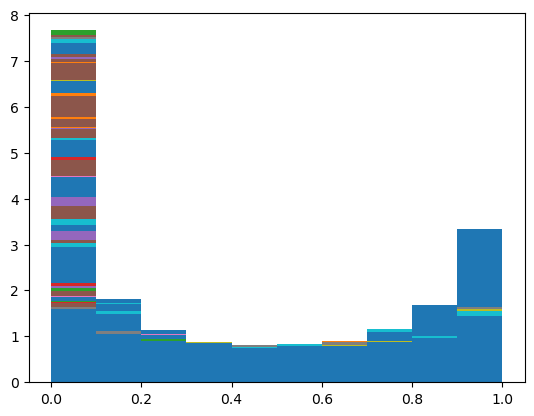

In [8]:
df = pd.DataFrame(columns=["rep", "f", "P", "tr", "copia", "JS"]) #DATA FRAME THAT WILL INCLUDE THE JS

i = -1
dict_array_for_dist = dict()
for v in LOI:
    if v == 'emp':
        i = i + 1
        n, bins_emp, patches = plt.hist(LCS[v], density=True) # empirical distribution
        dict_array_for_dist[v] = n
        x = np.array(bins_emp[:-1]) + ((bins_emp[1]-bins_emp[0])/2)
        JS = '' #no JS.
    elif '-c' not in v:
        i = i + 1
        n, bins, patches = plt.hist(LCS[v], bins_emp, density=True)
        dict_array_for_dist[v] = n
        x = np.array(bins[:-1]) + ((bins[1]-bins[0])/2)
        
        js = distance.jensenshannon(dict_array_for_dist['emp'], dict_array_for_dist[v])
        JS = ', JS = %.3f'%round(js,3)
        param = re.findall(r'\d+', v)
        
        #INCLUDE JS IN THE DATAFRAME
        row = dict()
        row['rep'] = [int(param[0])]
        row['f'] = [int(param[1])/100]
        row['P'] = [int(param[2])/100]
        row['tr'] = [int(param[3])/100]
        row['copia'] = ['%d copies'%len(copies)]
        row['JS'] = [js]
        df_row = pd.DataFrame.from_dict(row)
        df = pd.concat([df, df_row], ignore_index=True)

df = df.sort_values(by=['f','P','tr','JS'])
dfJS = df.copy()

In [9]:
df = dfJS.copy()
print(len(df))

f_values = sorted(list(set(df.f)))
P_values = sorted(list(set(df.P)))
p_tr_values = sorted(list(set(df.tr)))

print('f ', f_values)
print('P ', P_values)
print('tr', p_tr_values)

df_sort = df.sort_values(by=['JS'])
print('selected values = ')
print(df_sort.head(1))

180
f  [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
P  [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
tr [0.0, 0.25, 0.5, 0.75, 1.0]
selected values = 
    rep    f    P    tr      copia        JS
169   2  0.8  0.4  0.75  10 copies  0.037568


# Plot grids

In [10]:
###FIGURES SETUP
cm = 1/2.54
fs = 11
flf = 10*cm
fhf = 10*cm
plt.rc('axes', labelsize=fs, titlesize=fs)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('legend', fontsize=fs)
plt.rc('figure', figsize=(flf,fhf))
plt.rcParams['legend.title_fontsize'] = fs
plt.rcParams["legend.labelspacing"] = 0.25
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

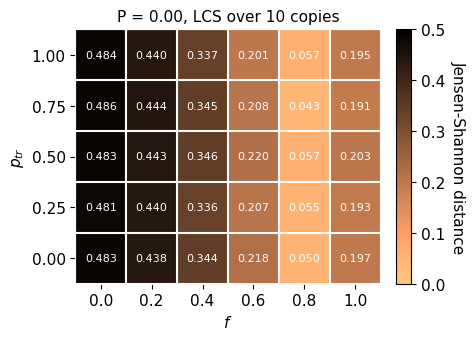

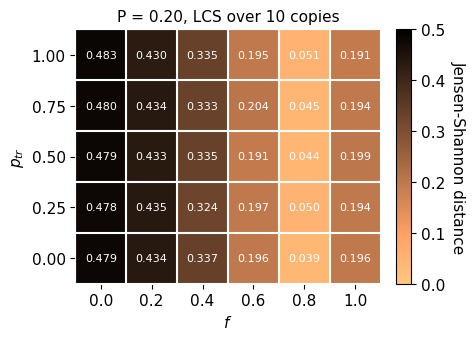

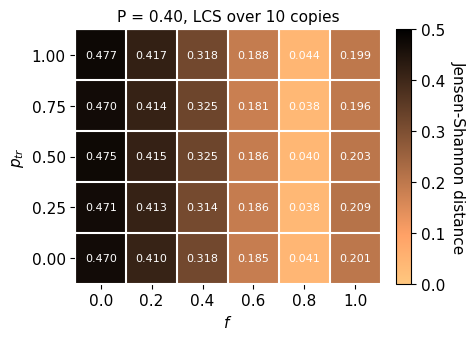

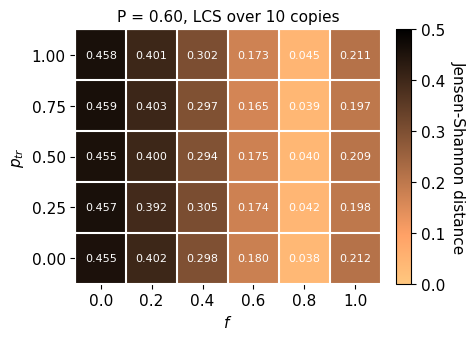

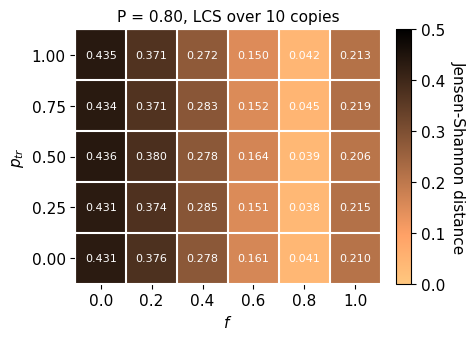

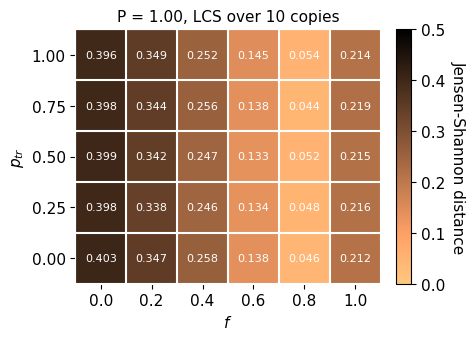

In [11]:
### Plot grids fixed p

parameters = {'f': f_values,
             'P': P_values,
             'tr': t_values}

dict_lab = {'f': '$f$',
             'P': '$p$',
             'tr': '$p_{tr}$'}

A_p_all =  func_both_alg_and_opt.get_A_all(parameters, 'P', 'f', 'tr', df)
func_both_alg_and_opt.plot_2d(A_p_all, 'P', 'f', 'tr', parameters, 'LCS over %d copies'%n_copies, dict_lab)

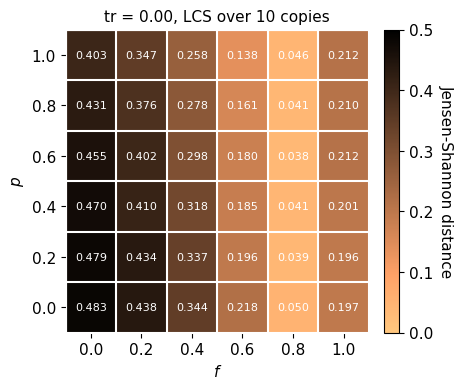

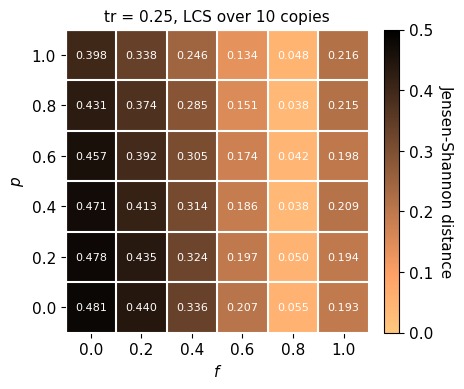

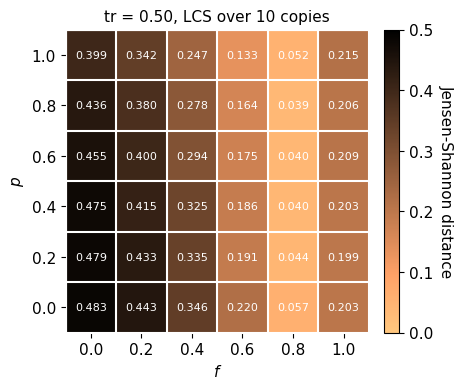

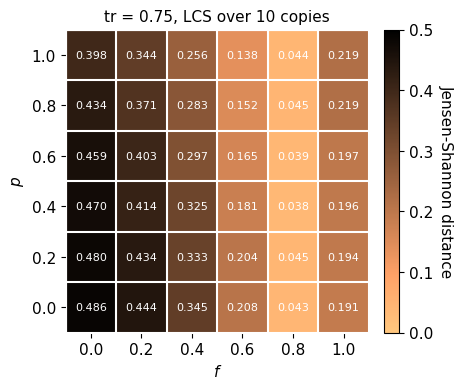

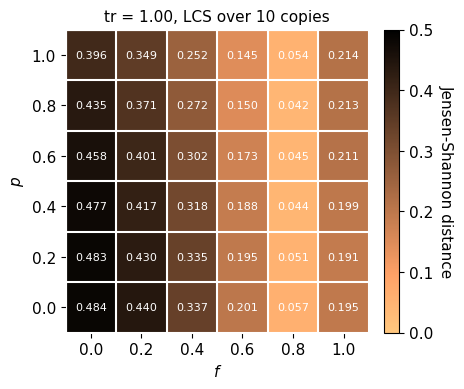

In [12]:
### Plot grids fixed p_tr
A_t_all =  func_both_alg_and_opt.get_A_all(parameters, 'tr', 'f', 'P', df)
func_both_alg_and_opt.plot_2d(A_t_all, 'tr', 'f', 'P', parameters, 'LCS over %d copies'%n_copies, dict_lab)

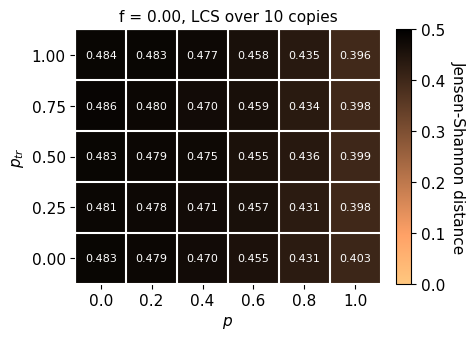

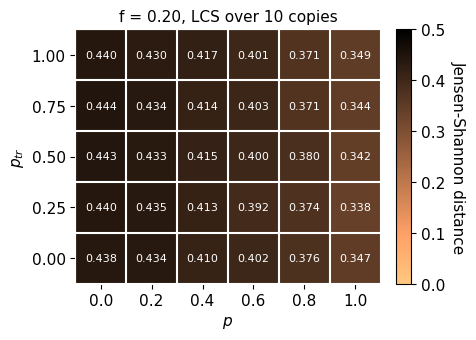

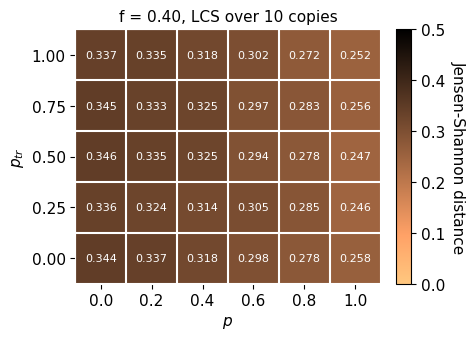

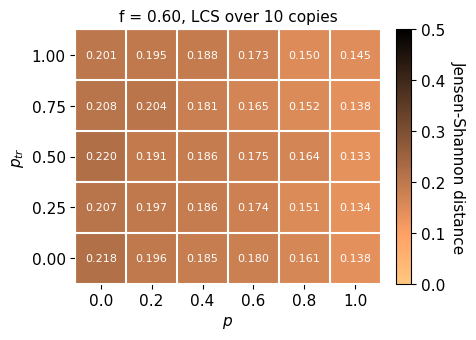

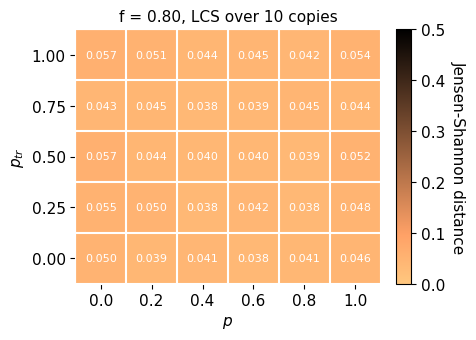

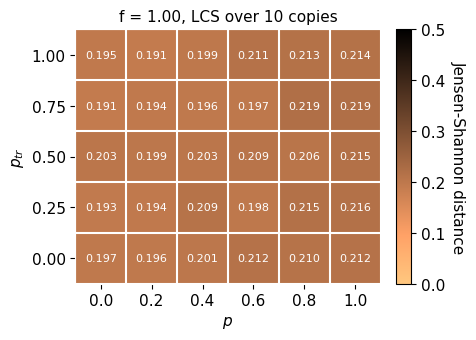

In [13]:
### Plot grids fixed f
A_f_all =  func_both_alg_and_opt.get_A_all(parameters, 'f', 'P', 'tr', df)
func_both_alg_and_opt.plot_2d(A_f_all, 'f', 'P', 'tr', parameters, 'LCS over %d copies'%n_copies, dict_lab)

/var/folders/pq/mypssjvs1xs0k9vkzrrw07b00000gn/T/ipykernel_1246/130199157.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=mpl.cm.get_cmap('copper').reversed()


Text(0, 0.5, 'Density')

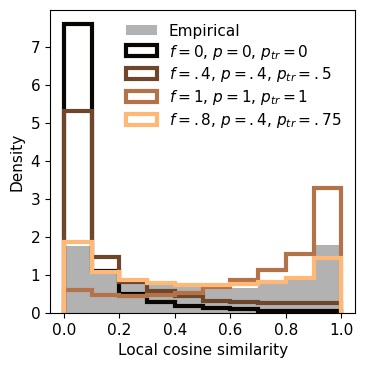

In [14]:
##PLOT A HISTOGRAM WITH THE DIFFERENT VALUES
cmap=mpl.cm.get_cmap('copper').reversed()
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

colors = dict()
colors['rep2f80p40t75'] = cmap(norm(float(df[(df['rep']==2) & (df['f']==0.8) & (df['P']==0.4)\
                       & (df['tr']==0.75)\
                       & (df['copia']=='%d copies'%10)].JS)))

colors['rep2f40p40t50'] = cmap(norm(float(df[(df['rep']==2) & (df['f']==0.4) & (df['P']==0.4)\
                       & (df['tr']==0.5)\
                       & (df['copia']=='%d copies'%10)].JS)))


colors['rep2f0p0t0'] = cmap(norm(float(df[(df['rep']==2) & (df['f']==0) & (df['P']==0)\
                       & (df['tr']==0)\
                       & (df['copia']=='%d copies'%10)].JS)))

colors['rep2f100p100t100'] = cmap(norm(float(df[(df['rep']==2) & (df['f']==1) & (df['P']==1)\
                       & (df['tr']==1)\
                       & (df['copia']=='%d copies'%10)].JS)))
colors['emp'] = '#00FF3D'

labels = dict()
labels['emp'] = 'Empirical'
labels['rep2f80p40t75'] = '$f=.8$, $p = .4$, $p_{tr} = .75$'
labels['rep2f100p100t100'] = '$f=1$, $p = 1$, $p_{tr} = 1$'
labels['rep2f40p40t50'] = '$f=.4$, $p = .4$, $p_{tr} = .5$'
labels['rep2f0p0t0'] = '$f=0$, $p = 0$, $p_{tr} = 0$'

n, bins_emp, patches = plt.hist(LCS['emp'], bins = 10, density=True, alpha=0.3, histtype = 'bar', color = 'k', label =labels['emp'])
n, bins_emp, patches = plt.hist([LCS[v] for v in ['rep2f80p40t75','rep2f100p100t100','rep2f40p40t50','rep2f0p0t0']], bins = 10, density=True, alpha=1, histtype = 'step', color = [colors[v] for v in ['rep2f80p40t75','rep2f100p100t100','rep2f40p40t50','rep2f0p0t0']], label = [labels[v] for v in ['rep2f80p40t75','rep2f100p100t100','rep2f40p40t50','rep2f0p0t0']],linewidth = 3)
plt.legend(frameon = False)
plt.xlabel('Local cosine similarity')
plt.ylabel('Density')
#plt.savefig('LCS_triplets.pdf', format='pdf', bbox_inches = "tight", dpi = 2200)


# The end.